# Quem classifica a classe classificadora?

**Nome: Joana de Medeiros Oliveira Hulse Molinete**

### Introdução:
No presente notebook, busco construir, treinar e testar uma rede neural classificadora, utilizando de códigos de construção de uma rede neural em Python puro disponibilizado pelo professor discente Daniel Cassar. Pretendo enunciar as diferenças entre uma rede neural regressora e uma rede neural classificadora, implementando então uma nova função de perda, nova métrica de erro e alterando o processamento da última camada de neurônios, para que o output seja um valor que represente uma probabilidade de classes.

### Importando as bibliotecas necessárias:

In [1]:
import numpy as np
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from graphviz import Digraph

SEMENTE_ALEATORIA = 42

C:\Users\joana24003\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Dataset e separação de dados:

O dataset escolhido foi o Pima Indians Diabetes, disponível no Github, muito utilizado em problemas de classificação. Ele contém atributos numéricos e alvo binário, onde 1 significa "tem diabetes" e 0 significa "não tem diabetes". Dessa forma, como o target já está em formato binário, podemos apenas definir os atributos desejados. Os dados foram divididos em 80% para treinamento e 20% para testagem da rede neural.

In [2]:
url="https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv"
dataset = pd.read_csv(url)
FEATURES = ["Glucose", "BloodPressure", "Insulin", "BMI"]
TARGET = ["Outcome"]

df = dataset

df = df.dropna()
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Após separarmos um subconjunto de atributos relevantes (glicose, pressão sanguínea, insulina e IMC), devemos normalizá-los para um melhor desempenho e ajuste da rede. Faremos também a separação dos dados em conjuntos de treino (80%) e teste (20%).

In [3]:
indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size = 0.2, random_state = SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values.ravel()

X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values.ravel()

scaler = MinMaxScaler()
X_treino = scaler.fit_transform(X_treino) 
X_teste = scaler.transform(X_teste) # só transforma com base no treino para não ter vazamento de informação

### Rede neural:

Como dito anteriormente, a rede neural original foi disponibilizada pelo professor Daniel Cassar [1] e modificada para abranger problemas de classificação. As alterações consistem na implementação da função de perda "cross_entropy", que faz comparações entre as previsões da rede neural e o valor real, atribuindo pesos diferentes para cada erro de acordo com o quão a previsão se aproximou (ou afastou) do valor real. Além disso, dentro da classe Valor, foram implementados os métodos log(), que calcula o logaritmo natural da informação, e o método__rsub__() que calcula a subtração de um valor e uma instância da classe Valor começando da direita para a esquerda. Ambos os métodos foram utilizados na função de perda.

In [4]:
#!pip install graphviz
from graphviz import Digraph

def _tracar(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    vertices = set()
    arestas = set()

    def construir(v):
        """Função recursiva para traçar o grafo."""
        if v not in vertices:
            vertices.add(v)
            for progenitor in v.progenitor:
                arestas.add((progenitor, v))
                construir(progenitor)

    construir(folha)

    return vertices, arestas

def plota_grafo(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    grafo = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    vertices, arestas = _tracar(folha)

    for v in vertices:
        id_vertice = str(id(v))

        if hasattr(v, "rotulo") and (hasattr(v, "grad")):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f} | grad {v.grad:.3f}" + " }"

        elif hasattr(v, "rotulo"):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f}" + " }"

        else:
            texto = "{ " + f"data {v.data:.3f}" + " }"

        grafo.node(name=id_vertice, label=texto, shape="record")

        if v.operador_mae:
            grafo.node(name=id_vertice + v.operador_mae, label=v.operador_mae)
            grafo.edge(id_vertice + v.operador_mae, id_vertice)

    for vertice1, vertice2 in arestas:
        grafo.edge(str(id(vertice1)), str(id(vertice2)) + vertice2.operador_mae)

    return grafo

### Função de perda Binary Cross-Entropy:

Por se tratar de um problema de classificação, precisamos alterar a função de perda que penaliza nosso algoritmo. A função escolhida foi a *Binary Cross-Entropy*, que utiliza da fórmula abaixo [2][3] para calcular as penalizações da rede:

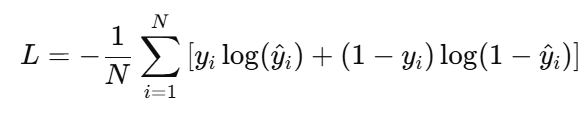

Onde $n$ representa o número total de exemplos no dataset. No entanto, é necessário adicionarmos um valor muito baixo ($\epsilon$) somando ao valor em que será aplicada a função logarítmica, para evitar que o log resulte em 0.

In [5]:
import random
import math

def binary_cross_entropy(y_true, y_pred): # NOVA FUNÇÃO!
    """Calcula a função de perda Binary Cross-Entropy Loss para redes neurais de classificação binária"""
    eps = 1e-5  # evita log(0)
    n = len(y_true)
    erro_total = Valor(0)

    for i in range(n):
        y_p = y_pred[i]
        log_loss = - (y_true[i] * (y_p+eps).log() + (1 - y_true[i]) * (1 - y_p + eps).log())
        erro_total += log_loss

    return erro_total / n
    
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"

    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        if self.data >= 0:
            z = math.exp(-self.data)
            result = 1 / (1 + z)
        else:
            z = math.exp(self.data)
            result = z / (1 + z)

        resultado = Valor(result, (self,), "sig")

        def propagar_sig():
            sig_grad = resultado.data * (1 - resultado.data)
            self.grad += resultado.grad * sig_grad

        resultado.propagar = propagar_sig

        return resultado
        
    
    def log(self, base=math.e): # NOVO MÉTODO!
        """Realiza a operação: log(self)"""
        progenitor = (self, )
        data = math.log(self.data)
        operador_mae = "log"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_log():
            self.grad += resultado.grad / self.data
        
        resultado.propagar = propagar_log
        
        return resultado
        
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __rsub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return outro_valor + (self * -1)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor

    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [6]:
class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = Valor(0)
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()

        return dado_de_saida    
    
    def parametros(self):
        return self.pesos + [self.vies]

In [7]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for i in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)   
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

In [8]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

Definimos a arquitetura da rede neural tendo como entrada 4 valores ('Glucose', 'BloodPressure', 'BMI', 'Insulin') e contendo 3 camadas ocultas, as primeiras com 4 neurônios e a última com 3 neurônios. A saída é um único valor, já que se trata de uma rede neural classificadora.

In [9]:
x = X_treino

NUM_DADOS_DE_ENTRADA = 4
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [4, 3, 3]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

### Treinando a rede neural:

Para o treinamento, utilizei o mesmo código que o dado no exemplo do professor discente, com 200 épocas e uma taxa de aprendizado de 0,01. Além disso, foi definido o método de classificação das previsões utilizando a lógica que se a porcentagem (em valor decimal) for maior ou igual do que 50% (0.5) de ter diabetes, classifica-se como 1 ("tem diabetes") e se for menor classifica-se como 0 ("não tem diabetes").

In [11]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.01

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in X_treino:
        previsao = minha_mlp(exemplo).sig()
        y_pred.append(previsao)

    # loss
    loss = binary_cross_entropy(y_treino, y_pred)

    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()
   
    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - (p.grad * TAXA_DE_APRENDIZADO)
        
    # acurácia
    if epoca % 10 == 0 or epoca == NUM_EPOCAS - 1:
        y_pred_classes = []
        for y in y_pred:
            if y.sig().data >= 0.5:
                y_pred_classes.append(1)
            else:
                y_pred_classes.append(0)
        
        acertos = 0
        
        for y_t, y_p in zip(y_treino, y_pred_classes):
            if y_t == y_p:
                acertos += 1
            else:
                continue
        acuracia = acertos/len(y_treino)
        print(f'época: {epoca}, loss: {loss.data:.4f}, acurácia: {acuracia}')

época: 0, loss: 0.7370, acurácia: 0.3469055374592834
época: 10, loss: 0.7367, acurácia: 0.3469055374592834
época: 20, loss: 0.7365, acurácia: 0.3469055374592834
época: 30, loss: 0.7362, acurácia: 0.3469055374592834
época: 40, loss: 0.7359, acurácia: 0.3469055374592834
época: 50, loss: 0.7357, acurácia: 0.3469055374592834
época: 60, loss: 0.7354, acurácia: 0.3469055374592834
época: 70, loss: 0.7352, acurácia: 0.3469055374592834
época: 80, loss: 0.7349, acurácia: 0.3469055374592834
época: 90, loss: 0.7347, acurácia: 0.3469055374592834
época: 99, loss: 0.7345, acurácia: 0.3469055374592834


### Métrica de acurácia:

A métrica de análise utilizada foi a acurácia, onde se divide o número de previsões corretas pelo número total de previsões, tendo assim uma comparação entre os valores previstos e os valores reais.

In [15]:
y_pred_teste = []
for exemplo in X_teste:
    previsao = minha_mlp(exemplo)
    y_pred_teste.append(previsao)

y_pred_classes = [1 if y.data >= 0.5 else 0 for y in y_pred_teste]
acuracia_teste = accuracy_score(y_teste, y_pred_classes)
print(f"Acurácia no teste: {acuracia_teste:.4f}")

Acurácia no teste: 0.6429


## Conclusão

O objetivo de construir uma rede neural classificadora do zero em Python puro foi alcançado, apesar dos resultados não terem sido satisfatórios. Algumas modificações se fizeram importantes, visto que partimos de uma rede neural regressora disponibilizada na matéria de Redes Neurais e Algoritmos Genéticos, como a substituição da função de perda pela função de Entropia Binária Cruzada, o uso da acurácia como métrica de desempenho e a aplicação da função sigmoide na camada de saída para geração de probabilidades.

Pude evidenciar não apenas a aplicabilidade de redes neurais em tarefas de classificação, mas também um entendimento mais profundo dos seus componentes fundamentais ao construir e treinar a rede passo a passo, sem o uso de bibliotecas prontas importadas do Python.

### Referências:

[1] CASSAR, Daniel. Redes Neurais e Algoritmos Genéticos. 2025. ATP-303 NN 4.2 - Notebook MLP, material de aula.

[2] Loss Functions in Deep Learning (Binary Cross-Entropy). Geeks for geeks, 2025. Disponível em: https://www.geeksforgeeks.org/loss-functions-in-deep-learning/ 

[3] SHAH, Deval. Understanding Binary Cross-Entropy and Log Loss for Effective Model Monitoring. Coralogix, 2023.  Disponível em: https://coralogix.com/ai-blog/understanding-binary-cross-entropy-and-log-loss-for-effective-model-monitoring/